# NB08 — TVSum Quantitative Evaluation

**Goal**: Conduct a rigorous statistical comparison between the BiLSTM and Transformer architectures using ranking, regression, and selection-based metrics.

### Evaluation Suite:
1. **Ranking Metrics**: Spearman’s Rho ($\rho$) and Kendall’s Tau ($\tau$).
2. **Regression Metrics**: Mean Squared Error (MSE) and Mean Absolute Error (MAE).
3. **Selection Metrics**: Top-K Overlap @ 15% budget.
4. **Statistical Significance**: Wilcoxon signed-rank test.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import math
from scipy.stats import spearmanr, kendalltau, wilcoxon
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Kaggle Environment Setup
IS_KAGGLE = Path("/kaggle/input").exists()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if IS_KAGGLE:
    FEATURES_PATH = Path("/kaggle/input/tvsum-features/tvsum_features.npy")
    INDEX_PATH = Path("/kaggle/input/tvsum-frame-index/tvsum_frame_index.parquet")
    TARGETS_PATH = Path("/kaggle/input/tvsum-targets/tvsum_targets.parquet")
    VAL_SPLIT_PATH = Path("/kaggle/input/tvsum-val/tvsum_val.txt")
    BILSTM_PATH = Path("/kaggle/input/tvsum-bilstm-v1/tvsum_bilstm_v1.pth")
    TRANSFORMER_PATH = Path("/kaggle/input/tvsum-transformer-v1/tvsum_transformer_v1.pth")
    # Supplemental Index containing categories
    SUPP_INDEX_PATH = Path("/kaggle/input/tvsum-index/tvsum_index.csv")
    RESULTS_DIR = Path("/kaggle/working/metrics")
    FIGURES_DIR = Path("/kaggle/working/figures")
else:
    FEATURES_PATH = Path("data/processed/tvsum_features.npy")
    INDEX_PATH = Path("data/processed/tvsum_frame_index.parquet")
    TARGETS_PATH = Path("data/processed/tvsum_targets.parquet")
    VAL_SPLIT_PATH = Path("data/processed/splits/tvsum_val.txt")
    BILSTM_PATH = Path("models/tvsum_bilstm_v4.pth")
    TRANSFORMER_PATH = Path("models/tvsum_transformer_v2.pth")
    SUPP_INDEX_PATH = Path("data/processed/tvsum_index.csv")
    RESULTS_DIR = Path("results/metrics")
    FIGURES_DIR = Path("reports/figures/metrics")

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f"Device: {DEVICE}")

Device: cuda


## 1. Architecture Definitions & Data Loading

Redefining the models to match the weights saved in the `.pth` files.

In [2]:
class CompactBiLSTM(nn.Module):
    def __init__(self, input_dim=960, bottleneck_dim=256, hidden_dim=128):
        super().__init__()
        self.projection = nn.Sequential(
            nn.Linear(input_dim, bottleneck_dim), nn.LayerNorm(bottleneck_dim),
            nn.ReLU(), nn.Dropout(0.3)
        )
        self.lstm = nn.LSTM(bottleneck_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 1)
    def forward(self, x): 
        x = self.projection(x)
        out, _ = self.lstm(x)
        return self.fc(out)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    def forward(self, x): return x + self.pe[:x.size(1), :]

class InterpretableTransformerLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=512, dropout=0.3):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1, self.norm2 = nn.LayerNorm(d_model), nn.LayerNorm(d_model)
        self.dropout1, self.dropout2 = nn.Dropout(dropout), nn.Dropout(dropout)
    def forward(self, src):
        src2, attn_weights = self.self_attn(src, src, src, need_weights=True)
        src = self.norm1(src + self.dropout1(src2))
        src2 = self.linear2(self.dropout(torch.relu(self.linear1(src))))
        src = self.norm2(src + self.dropout2(src2))
        return src, attn_weights

class TransformerSummarizerV2(nn.Module):
    def __init__(self, input_dim=960, d_model=256, nhead=4, num_layers=3):
        super().__init__()
        self.project = nn.Sequential(nn.Linear(input_dim, d_model), nn.LayerNorm(d_model), nn.ReLU(), nn.Dropout(0.3))
        self.pos_enc = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([InterpretableTransformerLayer(d_model, nhead) for _ in range(num_layers)])
        self.head = nn.Linear(d_model, 1)
    def forward(self, x): 
        x = self.pos_enc(self.project(x))
        for layer in self.layers: x, _ = layer(x)
        return self.head(x)

# Weight Loading
features = np.load(FEATURES_PATH)
index_df = pd.read_parquet(INDEX_PATH)
targets_df = pd.read_parquet(TARGETS_PATH)
with open(VAL_SPLIT_PATH, 'r') as f: val_ids = [l.strip() for l in f if l.strip()]

bilstm = CompactBiLSTM().to(DEVICE)
bilstm.load_state_dict(torch.load(BILSTM_PATH, map_location=DEVICE))
bilstm.eval()

transformer = TransformerSummarizerV2().to(DEVICE)
transformer.load_state_dict(torch.load(TRANSFORMER_PATH, map_location=DEVICE))
transformer.eval()

# Category Map from Supplemental Index
supp_index = pd.read_csv(SUPP_INDEX_PATH)
VIDEO_TO_CAT = dict(zip(supp_index['video_id'], supp_index['category']))

print("Models and data successfully loaded.")

Models and data successfully loaded.


## 2. Evaluation Loop

In [3]:
def calculate_topk_overlap(pred, gt, budget=0.15):
    k = max(1, int(len(pred) * budget))
    top_idx_pred = set(np.argsort(pred)[-k:])
    top_idx_gt = set(np.argsort(gt)[-k:])
    return len(top_idx_pred.intersection(top_idx_gt)) / k

results_records = []
for vid_id in val_ids:
    # Get indices for this video
    rows = index_df[index_df['video_id'] == vid_id].index
    if len(rows) == 0: 
        print(f"Warning: Video {vid_id} not found in index.")
        continue
    
    x = torch.FloatTensor(features[rows]).unsqueeze(0).to(DEVICE)
    y_gt = targets_df.iloc[rows]['importance_score'].values
    category = VIDEO_TO_CAT.get(vid_id, "Unknown")
    
    with torch.no_grad():
        p_bi = torch.clamp(bilstm(x), 0, 1).cpu().squeeze().numpy()
        p_tr = torch.clamp(transformer(x), 0, 1).cpu().squeeze().numpy()
    
    # Metrics BiLSTM
    rho_bi, _ = spearmanr(p_bi, y_gt, nan_policy='omit')
    tau_bi, _ = kendalltau(p_bi, y_gt, nan_policy='omit')
    mse_bi = mean_squared_error(y_gt, p_bi)
    mae_bi = mean_absolute_error(y_gt, p_bi)
    overlap_bi = calculate_topk_overlap(p_bi, y_gt)
    
    # Metrics Transformer
    rho_tr, _ = spearmanr(p_tr, y_gt, nan_policy='omit')
    tau_tr, _ = kendalltau(p_tr, y_gt, nan_policy='omit')
    mse_tr = mean_squared_error(y_gt, p_tr)
    mae_tr = mean_absolute_error(y_gt, p_tr)
    overlap_tr = calculate_topk_overlap(p_tr, y_gt)
    
    results_records.append({
        'video_id': vid_id, 'category': category,
        'rho_bi': rho_bi, 'tau_bi': tau_bi, 'mse_bi': mse_bi, 'mae_bi': mae_bi, 'overlap_bi': overlap_bi,
        'rho_tr': rho_tr, 'tau_tr': tau_tr, 'mse_tr': mse_tr, 'mae_tr': mae_tr, 'overlap_tr': overlap_tr
    })

eval_df = pd.DataFrame(results_records)
eval_df.to_csv(RESULTS_DIR / "tvsum_metrics.csv", index=False)
eval_df.style.background_gradient(cmap='viridis')

,video_id,category,rho_bi,tau_bi,mse_bi,mae_bi,overlap_bi,rho_tr,tau_tr,mse_tr,mae_tr,overlap_tr
0,4wU_LUjG5Ic,Parade,0.749212,0.556378,0.007853,0.068696,0.560000,0.611176,0.421913,0.010945,0.082643,0.440000
1,Bhxk-O1Y7Ho,Grooming an Animal,0.785742,0.563817,0.012839,0.097393,0.333333,0.749241,0.527824,0.012812,0.092940,0.274074
2,JgHubY5Vw3Y,Attempting Bike Tricks,0.664702,0.452569,0.019482,0.122173,0.534884,0.546965,0.358780,0.023353,0.122891,0.325581
3,LRw_obCPUt0,Making Sandwich,0.723052,0.499013,0.014707,0.099303,0.346154,0.708549,0.488319,0.011068,0.083470,0.320513
4,NyBmCxDoHJU,Dog Show,0.442455,0.300260,0.014021,0.097697,0.192982,0.373471,0.253853,0.012822,0.089804,0.263158
5,PJrm840pAUI,Parkour,0.303866,0.224144,0.011871,0.077407,0.207317,0.213154,0.151641,0.011871,0.077137,0.146341
6,Se3oxnaPsz0,Bee Keeping,0.732627,0.524464,0.021192,0.103757,0.414634,0.721762,0.518762,0.017655,0.098077,0.463415
7,_xMr-HKMfVA,Flash Mob Gathering,-0.028662,-0.015977,0.023061,0.119747,0.136364,0.016889,0.014363,0.020791,0.117777,0.068182
8,gzDbaEs1Rlg,Changing Vehicle Tire,0.521181,0.357567,0.013832,0.091238,0.453488,0.474209,0.330008,0.015306,0.094527,0.395349
9,vdmoEJ5YbrQ,Getting Vehicle Unstuck,0.356748,0.245765,0.009434,0.073836,0.275510,0.013732,0.013203,0.014314,0.090591,0.193878


## 3. Summary Statistics & Significance

In [4]:
# Aggregating only numeric columns
summary = eval_df.iloc[:, 2:].agg(['mean', 'std', 'median'])

try:
    stat, p_val = wilcoxon(eval_df['rho_bi'], eval_df['rho_tr'])
    print(f"Wilcoxon p-value (Spearman Rho): {p_val:.4f}")
except Exception as e:
    print(f"Significance test skipped: {e}")

summary

Wilcoxon p-value (Spearman Rho): 0.0137


,rho_bi,tau_bi,mse_bi,mae_bi,overlap_bi,rho_tr,tau_tr,mse_tr,mae_tr,overlap_tr
mean,0.525092,0.370800,0.014829,0.095125,0.345467,0.442915,0.307866,0.015094,0.094986,0.289049
std,0.260488,0.185688,0.004967,0.018019,0.145089,0.279996,0.194880,0.004243,0.014764,0.127329
median,0.592941,0.405068,0.013927,0.097545,0.339744,0.510587,0.344394,0.013568,0.091765,0.297293


## 4. Visual Analysis

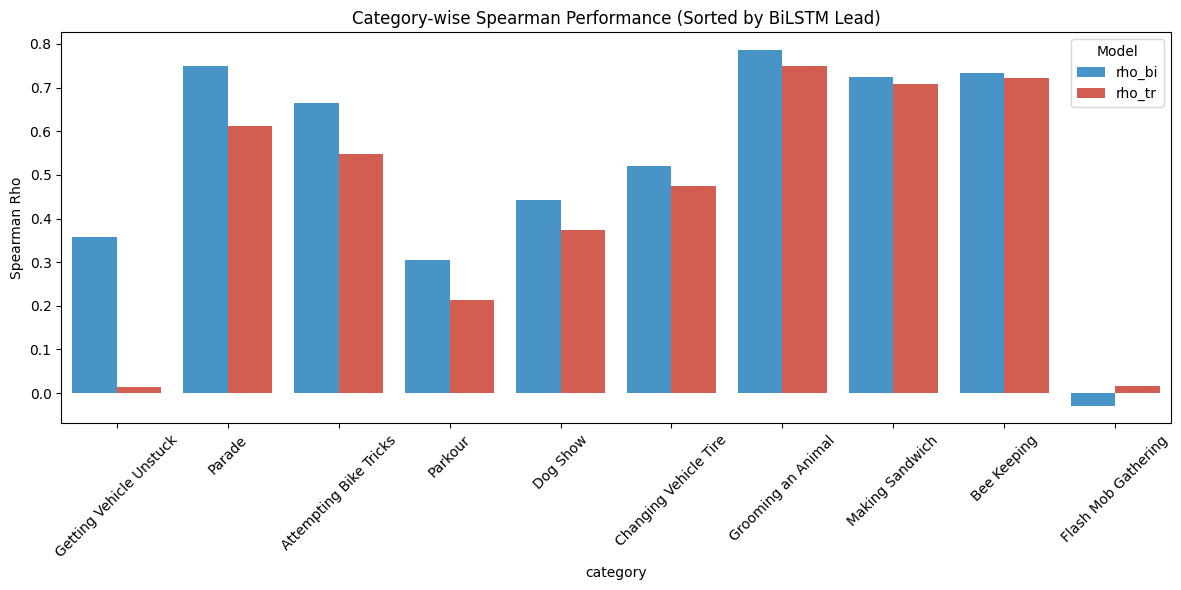

In [5]:
plt.figure(figsize=(12, 6))
# Calculate difference for sorting
diffs = eval_df.groupby('category')[['rho_bi', 'rho_tr']].mean()
diffs['diff'] = diffs['rho_bi'] - diffs['rho_tr']
sorted_cats = diffs.sort_values('diff', ascending=False).index

melted = eval_df.melt(id_vars='category', value_vars=['rho_bi', 'rho_tr'], var_name='Model', value_name='Spearman Rho')
sns.barplot(x='category', y='Spearman Rho', hue='Model', data=melted, palette=['#3498db', '#e74c3c'], order=sorted_cats)
plt.title("Category-wise Spearman Performance (Sorted by BiLSTM Lead)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "category_rho.png")
plt.show()